# Image Processing

by Felix Fritzen fritzen@mib.uni-stuttgart.de, December 2021

additional material for the course *Data Processing for Engineers and Scientists*

## Content
- image kernels: examples
- image filtering
- segmentation by thresholding
- advanced segmentation: filtering+thresholding
- region labeling for disconnected particles
- phase volume fractions
- generation of random microstructures
- erosion, dilation, morphological opening/closing
- image entropy
- two-point correlation function (2PC)
- using `skimage` (example: Euler number)

In [1]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as LA

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable

from numpy.fft import fft2, ifft2
from matplotlib import rc

import image_kernels as kernels
import image_operations as improcess

import skimage
from skimage.segmentation import flood_fill

############################################################################
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'], 'size':14})

gridls      = { 'linewidth' : 3, 'color' : '#AAAAAA', 'linestyle' : ':' }
legendstyle = dict(fontsize=16, facecolor='#DDDDDD', framealpha=1, \
                   loc='lower right', bbox_to_anchor = (0.975,0.025))
f_size      = (12,3.75  )

# define a few of the University's corporate design colors
Sblue = '#004191'
Slblue= '#00beff'
Smagenta='#ec008d'
Sgreen ='#8dc63f'

## Show some image kernels

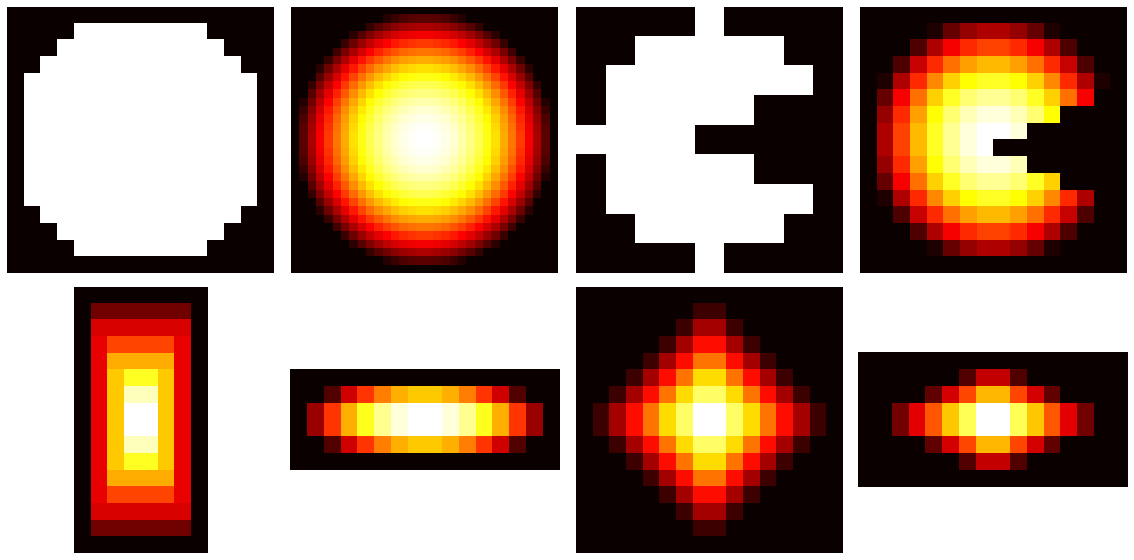

In [2]:
fig, ax = plt.subplots( 2,4,figsize=(16,8) )
ax = ax.flatten()

K = []

K.append( kernels.disc(16,kind='uniform') )
K.append( kernels.disc(32,kind='linear') )
K.append( kernels.pacman(9,kind='uniform') )
K.append( kernels.pacman(16,kind='linear') )

K.append( kernels.rectangle(n_x=8,n_y=16,kind='linear') )
K.append( kernels.disc(n_x=16, n_y=6,kind='linear') )
K.append( kernels.diamond(16,kind='linear') )
K.append( kernels.diamond(16,n_y=8,kind='linear') )
for i in range(8):
    ax[i].axis('off')
    ax[i].imshow( K[i].astype(float), cmap=plt.cm.hot )
    
plt.tight_layout()

## Application of the filter to grayscale images

- apply various filter to a grayscale image
- visulize the results including region zoom

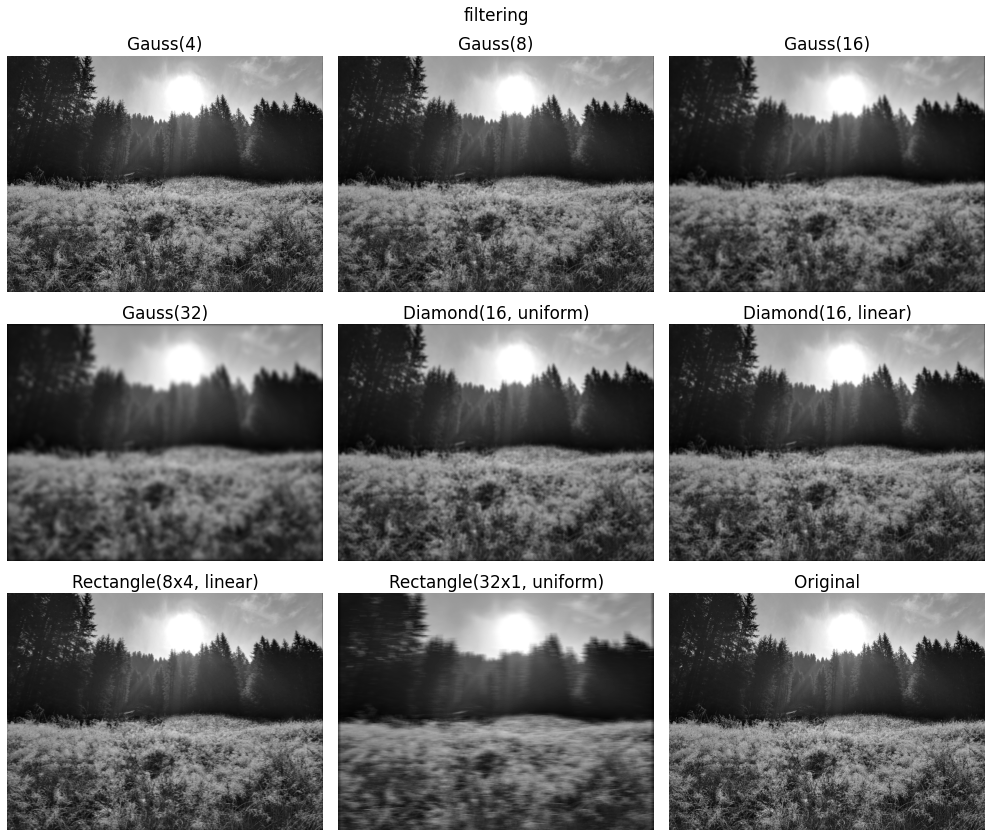

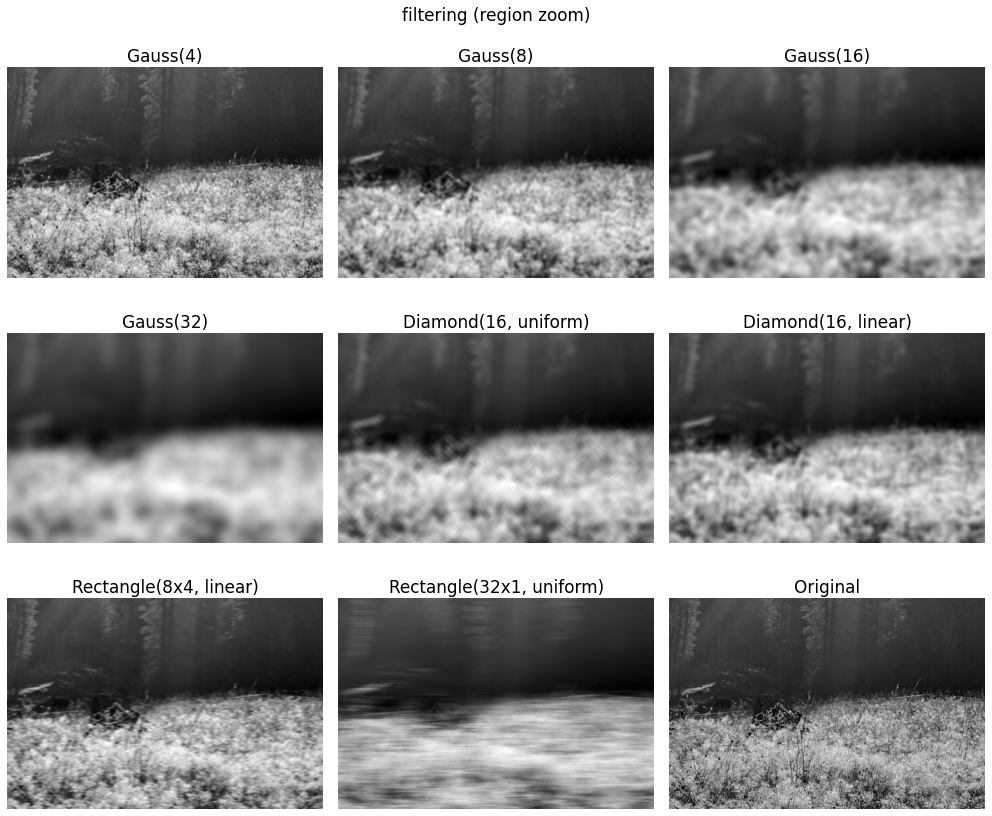

In [3]:
fig, ax = plt.subplots( 3,3,figsize=(14,12) )
ax = ax.flatten()
A = mpimg.imread('bw_img1.jpg')
f = []
pad = (32,32)
f.append(kernels.disc(4,kind='gauss'))
f.append(kernels.disc(8,kind='gauss'))
f.append(kernels.disc(16,kind='gauss'))
f.append(kernels.disc(32,kind='gauss'))
f.append(kernels.diamond(16,kind='uniform'))
f.append(kernels.diamond(16,kind='linear'))
f.append(kernels.rectangle(8,n_y=4,kind='linear'))
f.append(kernels.rectangle(32,n_y=1,kind='uniform'))

title_string = []
title_string.append('Gauss(4)')
title_string.append('Gauss(8)')
title_string.append('Gauss(16)')
title_string.append('Gauss(32)')
title_string.append('Diamond(16, uniform)')
title_string.append('Diamond(16, linear)')
title_string.append('Rectangle(8x4, linear)')
title_string.append('Rectangle(32x1, uniform)')
title_string.append('Original')

A = improcess.zero_padding(A, pad=pad)
f_A = fft2(A)
B = []
for i in range(9):
    if( i<8 ):
        k = improcess.embed_kernel( f[i].astype(float), image_size=(A.shape[0],A.shape[1]))
        B.append( improcess.un_pad( np.real( ifft2( f_A * fft2(k) ) ), pad ) ) 
    else:
        B.append( improcess.un_pad( A, pad ) )
    ax[i].axis('off')
    ax[i].set_title(title_string[i])
    ax[i].imshow(B[i], cmap=plt.cm.gray )
fig.suptitle('filtering')
fig.tight_layout()

fig, ax = plt.subplots( 3,3,figsize=(14,12) )
ax = ax.flatten()
img_region = ( slice(400,700), slice(500,950) )
for i in range(9):
    C = B[i][img_region]
    ax[i].axis('off')
    ax[i].set_title(title_string[i])
    ax[i].imshow(C, cmap=plt.cm.gray )
    
fig.suptitle('filtering (region zoom)')
fig.tight_layout()

## Segmentation: thresholding and filtering + thresholding

- thresholding as basic segmentation operation (bottom right plot)
- filtering $\blacktriangleright$ account for nonlocal information
- thresholding of the filtered image $\blacktriangleright$ improved performance in many situations

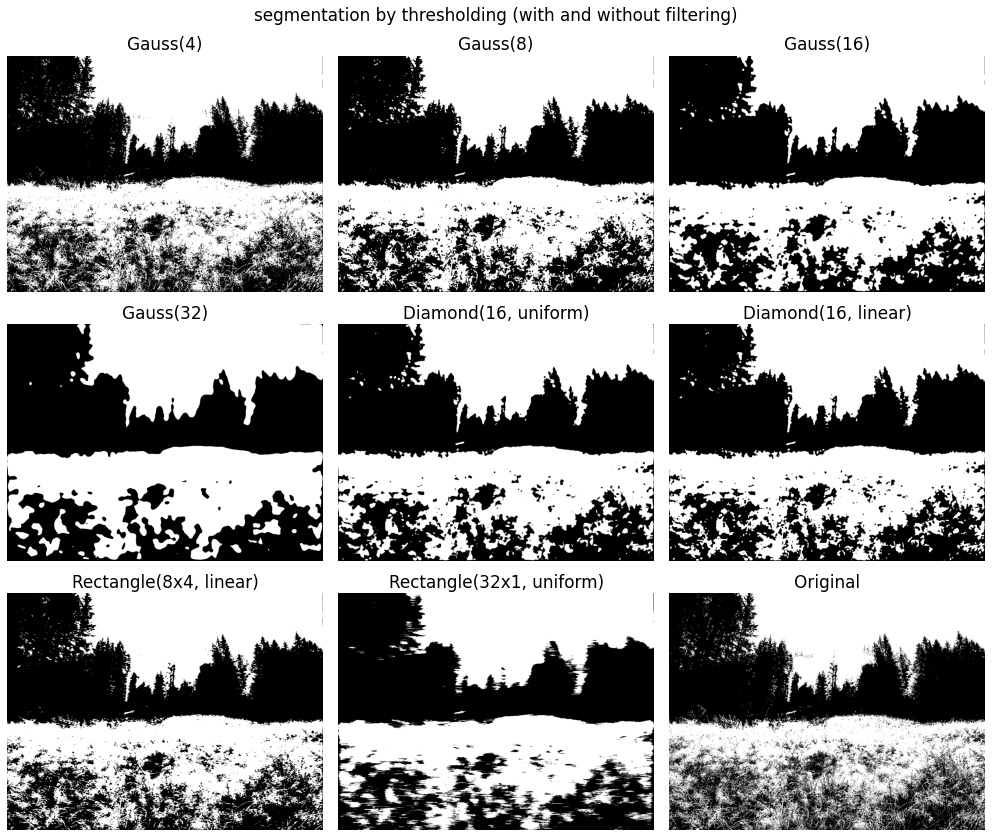

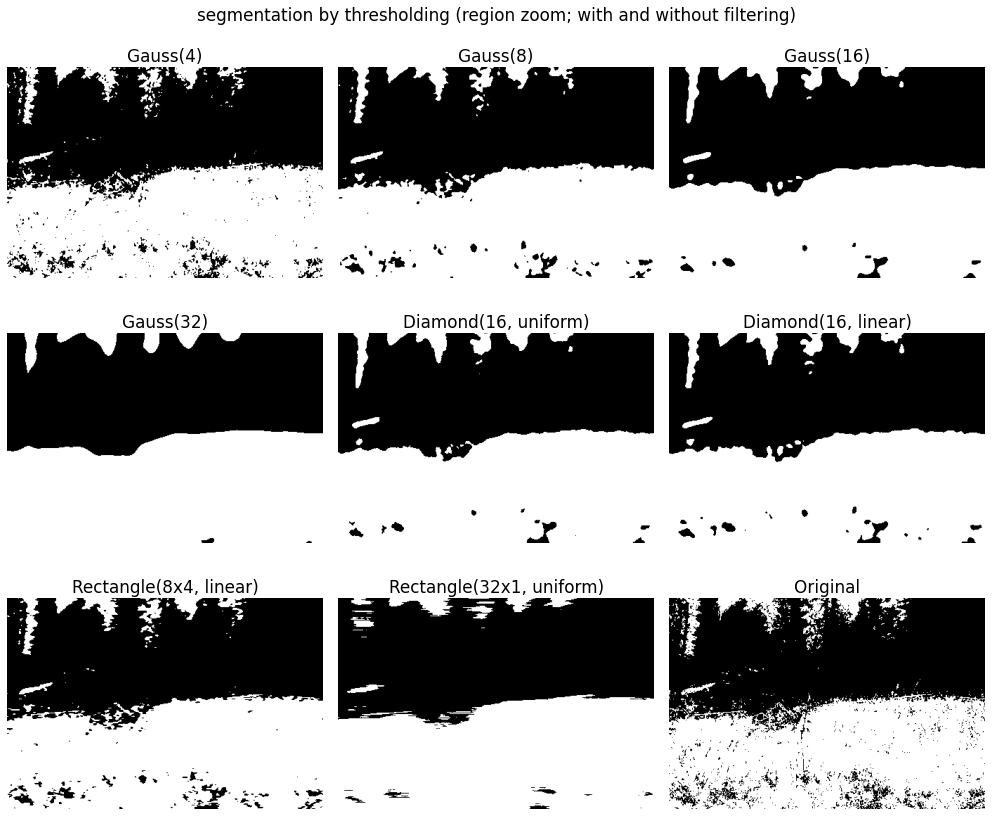

In [4]:
fig, ax = plt.subplots( 3,3,figsize=(14,12) )
ax = ax.flatten()
BW = []
theta = 0.3
for i in range(9):
    BW.append( B[i].astype('uint8') > theta * 255 )
    ax[i].axis('off')
    ax[i].set_title(title_string[i])
    ax[i].imshow(BW[i], cmap=plt.cm.gray )
fig.suptitle('segmentation by thresholding (with and without filtering)')
fig.tight_layout()

fig, ax = plt.subplots( 3,3,figsize=(14,12) )
ax = ax.flatten()
img_region = ( slice(400,700), slice(500,950) )
for i in range(9):
    C = BW[i][img_region]
    ax[i].axis('off')
    ax[i].set_title(title_string[i])
    ax[i].imshow(C, cmap=plt.cm.gray )
fig.suptitle('segmentation by thresholding (region zoom; with and without filtering)')

fig.tight_layout()

### Multi-phase segmentation
- use a grayscale image
- show how to segment the image into multiple phases

Text(0.5, 1.0, 'segmented image')

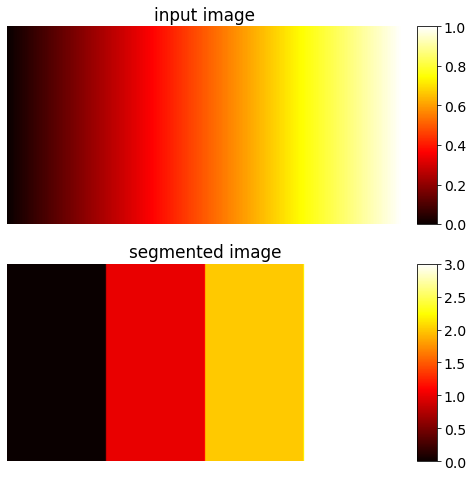

In [5]:
# gradient image
img = np.outer( np.ones(100), np.linspace(0,1,200) )

seg_img = np.full( img.shape, -1, dtype='int')

res_img = img.copy()

ct = 0
for theta in np.linspace(0,1,5)[1:]:
    idx=np.where((seg_img[:,:]<0) * (img[:,:] <= theta))
    seg_img[idx] = ct
    ct += 1

fig,ax = plt.subplots(2,1,figsize=(8,8))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes( 'right', size='5%', pad=0.2)
fig.colorbar( ax[0].imshow(img, cmap=plt.cm.hot), cax=cax )
ax[0].axis('off')
ax[0].set_title('input image')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes( 'right', size='5%', pad=0.2)
fig.colorbar( ax[1].imshow(seg_img, cmap=plt.cm.hot), cax=cax )
ax[1].axis('off')
ax[1].set_title('segmented image')


## Generation of random microstructures

- seed centers for differently sized discs
- *draw* the discs using convolution and predefined disc kernels

Text(0.5, 1.0, 'random periodic microstructure')

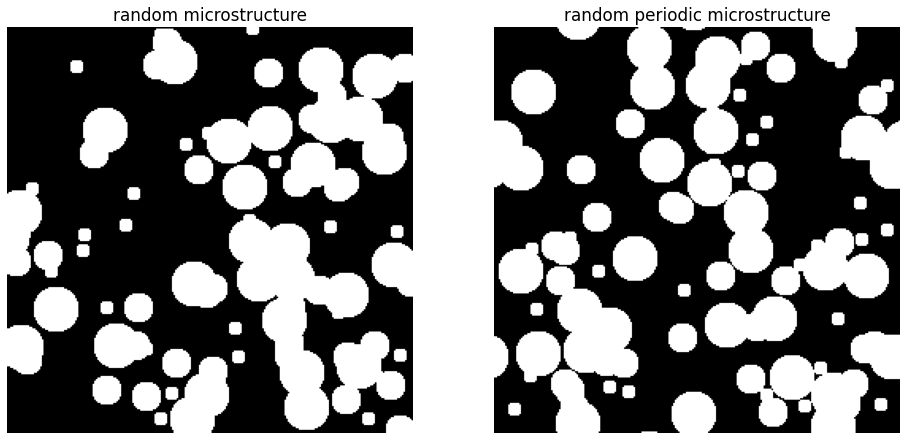

In [6]:
N       = 100 
radii   = np.array( [ 15, 31, 49 ], dtype='uint8' )


def circular_ms( N = 100, n_x = 400, n_y = None, radii = [15], periodic = False ):
    """
    Generates an image with N inclusions, dimensions n_x x n_y and random radii drawn
    from the discrete set radii
    
    Parameters:
    -----------
    
    N (int)       number of particle centers
    n_x (int)     first dimension
    n_y (int)     second dimension (optional; else: n_x)
    radii (np.array) discrete set of radii to be chosen randomly
    periodic (bool) should the microstructure be periodic?
    
    Returns:
    --------
    ms_img (np.array) n_x x n_y numpy array (dtype='uint8'); 0 -> background; 1 -> particles
    
    """
    radii = np.array(radii).astype('int')
    n_radii = len(radii)
    if ( n_y == None ):
        n_y = n_x

    # image size; random disc centers; random radius
    x, y    = rnd.randint( 0, n_x, size=N ), rnd.randint( 0, n_y, size=N )
    R       = rnd.randint( 0, n_radii, size=N)

    # define the disc kernels
    disc_kern = []
    for r in range(n_radii):
        disc_kern.append( kernels.disc( radii[r], kind='uniform' ) )

    # create virgin binary image
    ms_img = np.zeros([ n_x, n_y ], dtype='bool')

    TOL = 1e-6
    for i_rad in range(n_radii):

        k = disc_kern[i_rad]
        F = np.zeros([ n_x, n_y ])

        idx = np.where( R == i_rad )
        for j in idx:
            F[ x[j], y[j] ] = 1

        # 'draw' the circles via convolution
        if( periodic ):
            f = ( ifft2( fft2(F) * fft2( improcess.embed_kernel(k, F.shape) )).real > TOL )
        else:
            f = ( improcess.convolution( F, k ) > TOL )
            
        # overlay the current circles on the existing microstructure (no collision detection)
        ms_img = np.maximum( ms_img , f )
    return ms_img

ms_img = circular_ms( N, n_x = 256, radii=[10,20,30])
fig, ax = plt.subplots(1,2,figsize=(16,9))
ax[0].imshow(ms_img, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('random microstructure')

ms_img = circular_ms( N, n_x = 256, radii=[10,20,30], periodic=True)

ax[1].imshow(ms_img, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('random periodic microstructure')

## Region labeling

Algorithm

- load image; convert to unsigned integer (of sufficient size!)
- the phase to be considered for region labeling is phase 1; intialize region counter `R=1`
- run through all pixels
- whenever facing a pixel with `reg[i,j]==1`
    - increment region counter `R`
    - flood fill from coordinate `[i,j]` with a new region label `R` as *color*
- once finished there remains no pixel with value 1 $\blacktriangleright$ shift all pixels with values > 1 back by one (**attention** substraction from unsigned integers is a dangerous operation; type conversion preferred)
- decrement `R`; now `R` is the number of regions found
- (optional) show results

found 11 particles/regions
phase   0, vol. frac.:   78.856 %
phase   1, vol. frac.:    1.193 %
phase   2, vol. frac.:    1.413 %
phase   3, vol. frac.:    1.430 %
phase   4, vol. frac.:    0.715 %
phase   5, vol. frac.:    1.430 %
phase   6, vol. frac.:    2.125 %
phase   7, vol. frac.:    5.160 %
phase   8, vol. frac.:    1.430 %
phase   9, vol. frac.:    3.388 %
phase  10, vol. frac.:    1.430 %
phase  11, vol. frac.:    1.430 %
---------------------------------------------------------
inclusion phase, vol. frac.:   21.144 % (reference:   21.144 %)


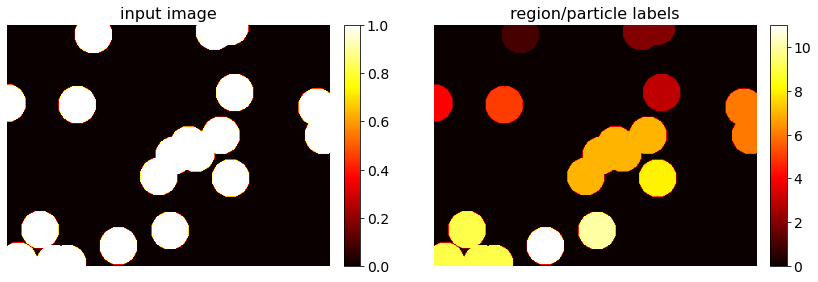

In [7]:
reg = circular_ms( N=20, n_x=300, n_y=400, radii=[48] ).astype('uint8')

fig, ax = plt.subplots( 1,2,figsize=(12,4) )

images = []
images.append( ax[0].imshow(reg, cmap=plt.cm.hot) )
ax[0].axis('off')
ax[0].set_title('input image',fontsize=16)

m, n = reg.shape[0], reg.shape[1]

R = 1 # we need to ensure that the first fill is already a new color
for i in range(m):
    for j in range(n):
        if( reg[i,j] == 1 ):
            R += 1
            reg = flood_fill(reg.astype('uint8'), (i,j), R)
reg = reg.astype('int32')
reg = np.maximum( 0, reg[:,:]-1 ) # shift back the region colors by one
reg = reg.astype('uint8')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size="5%", pad=0.2)
fig.colorbar( images[0], orientation='vertical', cax=cax )

R -= 1
print('found %d particles/regions' % (R) )

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size="5%", pad=0.2)

images.append( ax[1].imshow(reg, cmap=plt.cm.hot) )
fig.colorbar( images[1], orientation='vertical', cax=cax )

f = np.zeros(R+1)
for i_reg in range(1,R+1):
    f[i_reg] = (reg==i_reg).sum()  / reg.size
f[0] = 1- f[1:].sum()
for i_reg in range(R+1):
    print('phase %3d, vol. frac.: %8.3f %%' %( i_reg, f[i_reg]*100) )
print('---------------------------------------------------------')
print('inclusion phase, vol. frac.: %8.3f %% (reference: %8.3f %%)'\
      %( f[1:].sum()*100, (reg>0).sum()*100/reg.size ) )
ax[1].axis('off')
ax[1].set_title('region/particle labels',fontsize=16)
plt.tight_layout()

## Local volume fraction

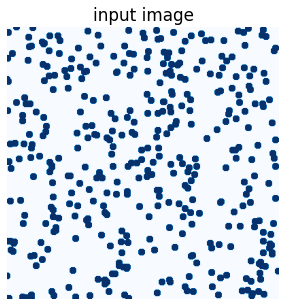

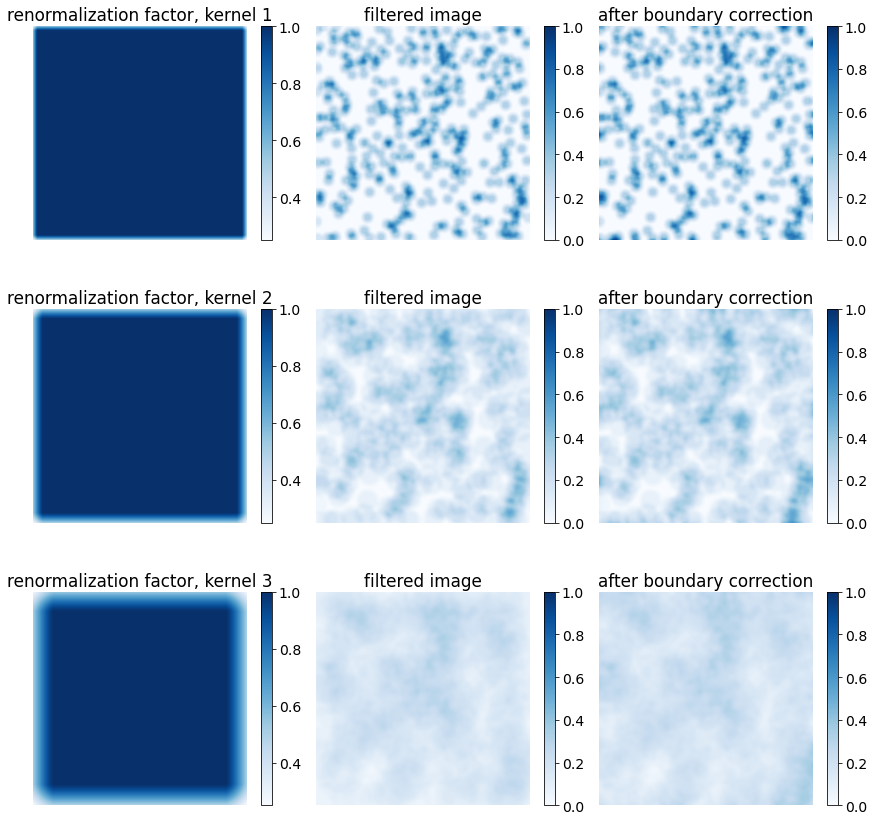

In [8]:
ms_img = circular_ms(N=400, n_x=400,n_y=400, radii=[12])
k = []
k.append( kernels.disc(20, kind='uniform') )
k.append( kernels.disc(40, kind='uniform') )
k.append( kernels.disc(80, kind='uniform') )

fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(ms_img, cmap=plt.cm.Blues)
ax.axis('off')
ax.set_title('input image')

fig,ax = plt.subplots(3,3,figsize=(12,12))
for i in range(3):
    k[i] = k[i]/k[i].sum()
    ref_img = np.ones(ms_img.shape)
    ref_img = improcess.convolution( ref_img, k[i], onepad=False)
    f = improcess.convolution( ms_img, k[i], onepad=False)
    im0=ax[i,0].imshow(ref_img, cmap=plt.cm.Blues)
    im1=ax[i,1].imshow(f,cmap=plt.cm.Blues,vmin=0,vmax=1)
    im2=ax[i,2].imshow(f/ref_img, cmap=plt.cm.Blues,vmin=0,vmax=1)
    
    divider = make_axes_locatable(ax[i,0])
    cax0 = divider.append_axes('right', size="5%", pad=0.2)
    divider = make_axes_locatable(ax[i,1])
    cax1 = divider.append_axes('right', size="5%", pad=0.2)
    divider = make_axes_locatable(ax[i,2])
    cax2 = divider.append_axes('right', size="5%", pad=0.2)
    
    fig.colorbar(im0,cax=cax0)
    fig.colorbar(im1,cax=cax1)
    fig.colorbar(im2,cax=cax2)
for i in range(3):
    ax[i,0].set_title('renormalization factor, kernel %d'%(i+1))
    ax[i,1].set_title('filtered image')
    ax[i,2].set_title('after boundary correction')
    for j in range(3):
        ax[i,j].axis('off')
plt.tight_layout()

## Erosion and dilation examples

volume fraction before/after erosion (image 1): 11.76 % / 0.08 %
volume fraction before/after erosion (image 2): 3.60 % / 0.08 %


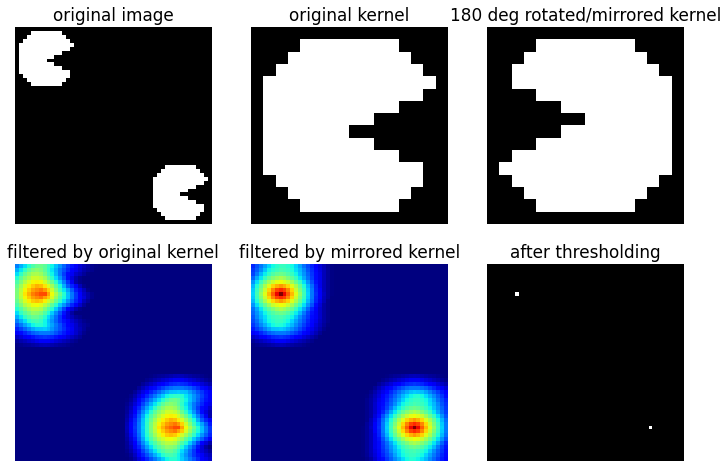

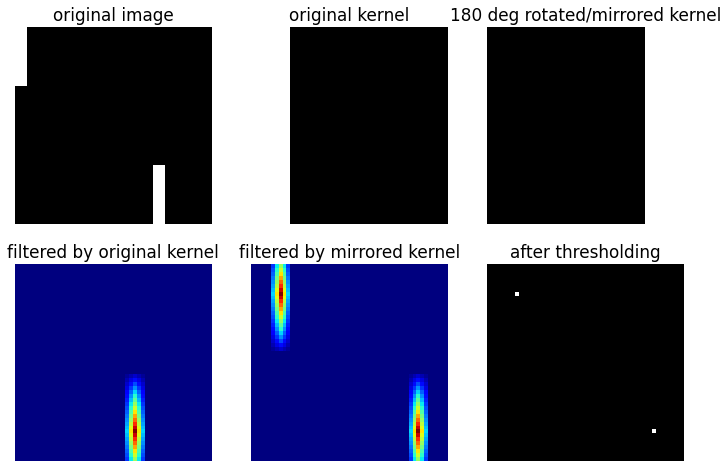

In [9]:
k = np.zeros((15,15))
k[:,:3] = 1
k = k/k.sum()

k_list = [kernels.pacman( 16, kind='uniform'), k]

ct=0

for k in k_list:
    ct+=1
    img = np. zeros((50,50))
    img[:k.shape[0], :k.shape[1]] = k
    # OPTIONAL: draw a second realization of the kernel (will yield to pixels in the eroded image)
    img[-k.shape[0]:, -k.shape[1]:] = k
    img = (img[:,:] > 1e-6)

    fig, ax = plt.subplots(2,3,figsize=(12,8))
    ax = ax.flatten()
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('original image')
    ax[1].imshow(k, cmap=plt.cm.gray)
    ax[1].set_title('original kernel')
    kmirror = np.fliplr(np.flipud(k))
    ax[2].imshow(kmirror, cmap=plt.cm.gray)
    ax[2].set_title('180 deg rotated/mirrored kernel')
    for i in range(ax.size):
        ax[i].axis('off')

    B = improcess.convolution(img, k)
    C = improcess.convolution(img, kmirror)
    # the actual eroded image:
    D = (C >= 0.999)
    ax[3].imshow(B, vmin=0, vmax=1, cmap=plt.cm.jet)
    ax[3].set_title('filtered by original kernel')
    ax[4].imshow(C, vmin=0, vmax=1, cmap=plt.cm.jet)
    ax[4].set_title('filtered by mirrored kernel')
    ax[5].imshow(D, vmin=0, vmax=1, cmap=plt.cm.gray)
    ax[5].set_title('after thresholding')
    print( 'volume fraction before/after erosion (image %d): %.2f %% / %.2f %%' \
          % ( ct, img.sum()/img.size * 100, D.sum()/D.size * 100) )

### Observations (erosion)
- erosion of the kernel must yield a single '1' pixel (proof of implementation)
- notable difference for a nonsymmetric kernel after filtering
- the mirrored kernel yields the expected result!
- only pixels at which the kernel can be placed without covering any '0' pixel will be assigned the value of '1'
- (**note:** test can also be performed with multiple nonoverlapping instances of the kernel)
- **note:** half the kernel size at all edges is subject to boundary effects, i.e. the usable region (if the image is nonperiodic) is smaller than the original size (and subsequent steps may reduce the usable size even further!); is 1 instead of 0 padding is used, then the boundary effect is reduced: then any overlay of the translated kernel that fully matches the image is also accepted

volume fraction before/after dilation: 0.72 % / 24.00 %


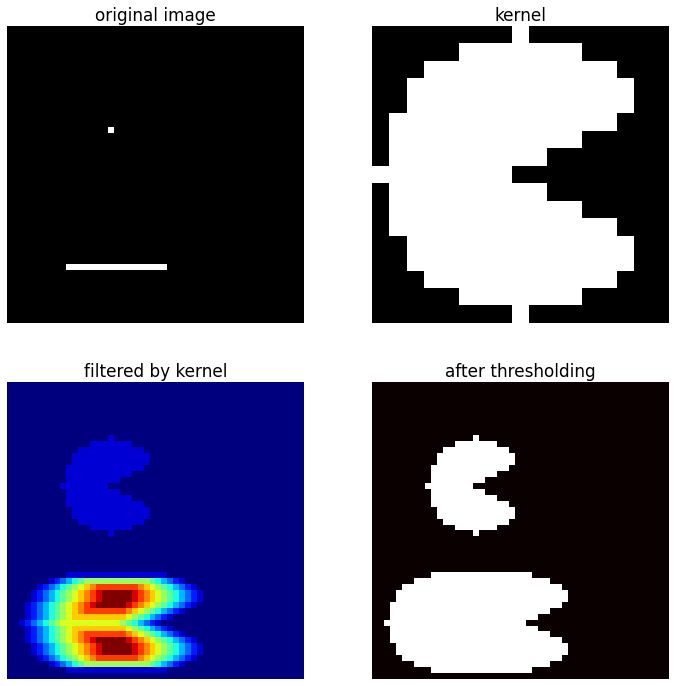

In [10]:
k = kernels.pacman( 17, kind='uniform')
img = np. zeros((50,50))
img[k.shape[0], k.shape[1]] = 1
#img[-k.shape[0], -k.shape[1]] = 1
img[40, 10:(k.shape[0]+10)] = 1
img = (img[:,:] > 1e-6)

fig, ax = plt.subplots(2,2,figsize=(12,12))
ax = ax.flatten()
ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('original image')
ax[1].imshow(k, cmap=plt.cm.gray)
ax[1].set_title('kernel')
for i in range(ax.size):
    ax[i].axis('off')
    
B = improcess.convolution(img, k)
# the actual dilated image:
C = (B >= 1e-3 * k.max() )

ax[2].imshow(B, cmap=plt.cm.jet)
ax[2].set_title('filtered by kernel')
ax[3].imshow(C, cmap=plt.cm.hot)
ax[3].set_title('after thresholding')

print( 'volume fraction before/after dilation: %.2f %% / %.2f %%' \
      % ( img.sum()/img.size * 100, C.sum()/C.size * 100) )

### Observations (dilation)
- a single pixel yields a realization of the kernel
- any pixel ever reached by the kernel positioned at any '1' pixel in the original image will be assigned '1' in the dilated image
- the boundary effect is not relevant (in contrast to the erosion)

## Morphological opening and closing

### Opening
- erode by filter
- dilate by filter

**effect:** having multiple small voids in the `1` phase in the filter range leads to holes (gaps are opened)

### Closing
- dilate by filter
- erode by filter

**effect:** will close small (w.r.t. filter size) gaps

In [11]:
def morph_opening( img, kernel, onepad=True ):
    return( improcess.dilate_by_filter( improcess.erode_by_filter( img, kernel, onepad=onepad ), kernel ))

def morph_closing( img, kernel, onepad=True ):
    return( improcess.erode_by_filter( improcess.dilate_by_filter( img, kernel ), kernel, onepad=onepad ))

### Examples for opening/closing
- take microstructure image
- add noise (sprinkles of white and black)
- show the effect of opening/closing


volume fractions:
  - original image      29.44 % (padvalue: 0)
  - after opening       28.86 % (padvalue: 0)
  - after closing       29.36 % (padvalue: 0)

volume fractions omitting boundary effects:
  - original image      30.06 % (padvalue: 0)
  - after opening       29.50 % (padvalue: 0)
  - after closing       30.39 % (padvalue: 0)

volume fractions:
  - original image      29.44 % (padvalue: 1)
  - after opening       28.88 % (padvalue: 1)
  - after closing       29.77 % (padvalue: 1)

volume fractions omitting boundary effects:
  - original image      30.06 % (padvalue: 1)
  - after opening       29.50 % (padvalue: 1)
  - after closing       30.39 % (padvalue: 1)


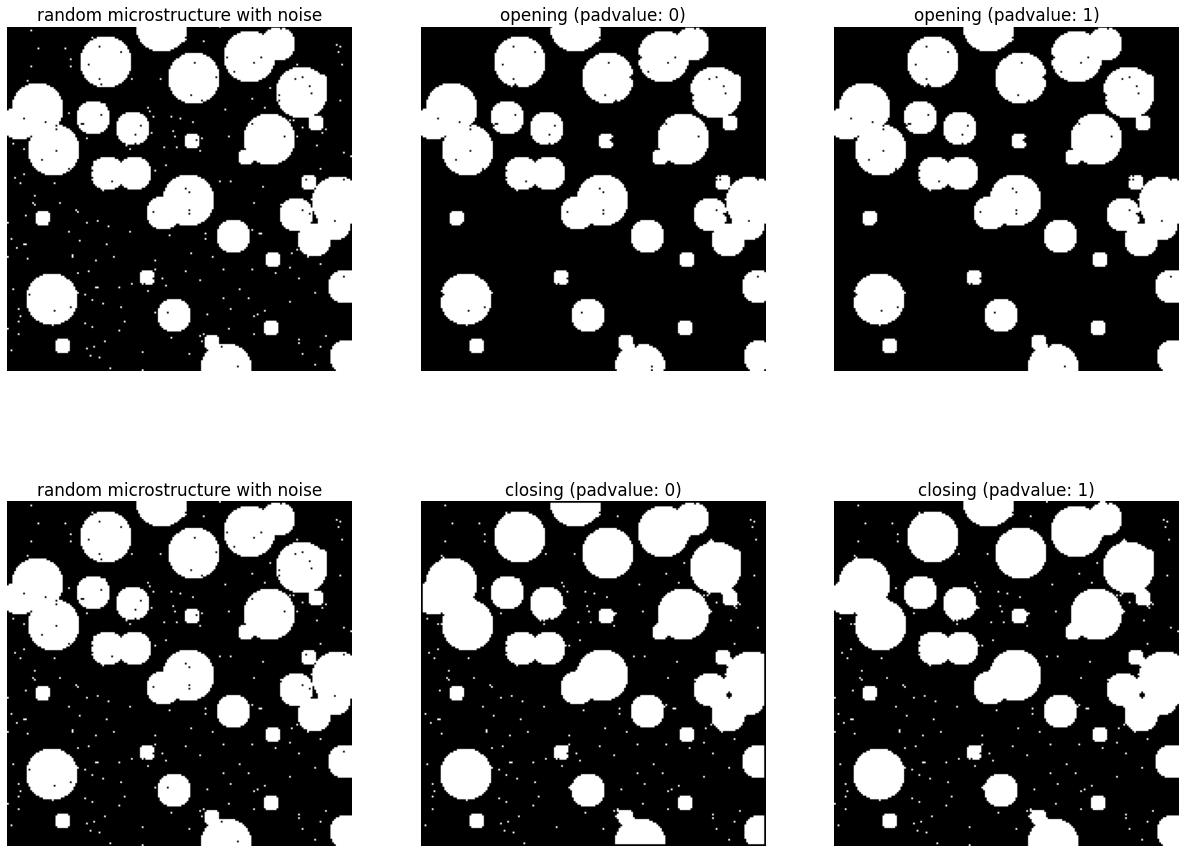

In [12]:
img = circular_ms( N=40, n_x=192, radii=[10,20,30])
k   = kernels.disc(3)

n_white = 240
white_x = np.random.randint( 0, img.shape[0], n_white )
white_y = np.random.randint( 0, img.shape[1], n_white )

for i in range(n_white):
    img[white_x[i], white_y[i]] = True

n_black = 240
black_x = np.random.randint( 0, img.shape[0], n_black )
black_y = np.random.randint( 0, img.shape[1], n_black )

for i in range(n_black):
    img[black_x[i], black_y[i]] = False
fig, ax = plt.subplots(2,3,figsize=(21,16))
ax[0,0].imshow(img, cmap=plt.cm.gray)
ax[0,0].axis('off')
ax[0,0].set_title('random microstructure with noise')
ax[1,0].imshow(img, cmap=plt.cm.gray)
ax[1,0].axis('off')
ax[1,0].set_title('random microstructure with noise')


for padvalue in range(2):
    
    img_open = morph_opening( img, k, onepad=(padvalue==1) )
    ax[0][1+padvalue].imshow(img_open, cmap=plt.cm.gray)
    ax[0][1+padvalue].axis('off')
    ax[0][1+padvalue].set_title('opening (padvalue: %d)'%(padvalue))

    img_closed = morph_closing( img, k, onepad=(padvalue==1) )
    ax[1][1+padvalue].imshow(img_closed, cmap=plt.cm.gray)
    ax[1][1+padvalue].axis('off')
    ax[1][1+padvalue].set_title('closing (padvalue: %d)'%(padvalue))

    print( '' )
    print( 'volume fractions:')
    print( '  - original image      %.2f %% (padvalue: %d)' %( img.sum()/img.size * 100, padvalue) )
    print( '  - after opening       %.2f %% (padvalue: %d)' %( img_open.sum()/img_open.size * 100, padvalue) )
    print( '  - after closing       %.2f %% (padvalue: %d)' %( img_closed.sum()/img_closed.size * 100, padvalue) )
    print( '' )
    print( 'volume fractions omitting boundary effects:')
    tmp_img = improcess.un_pad( img, k.shape )
    tmp_img_open = improcess.un_pad( img_open, k.shape )
    tmp_img_closed = improcess.un_pad( img_closed, k.shape )
    print( '  - original image      %.2f %% (padvalue: %d)' %( tmp_img.sum()/tmp_img.size * 100, padvalue) )
    print( '  - after opening       %.2f %% (padvalue: %d)' %( tmp_img_open.sum()/tmp_img_open.size * 100, padvalue) )
    print( '  - after closing       %.2f %% (padvalue: %d)' %( tmp_img_closed.sum()/tmp_img_closed.size * 100, padvalue) )


### Observations
- opening removes white sprinkles
- closing removes black sprinkles
- **attention** opening can lead to eroded boundaries (if black pixels occur close to the surface)
- **attention** closing can lead to thickened/rounded connections (if particles are very close)
- **attention** reduced boundary effects can be obtained by using 1 padding in the erosion step

$\blacktriangleright$ let's combine both! (note the small impact of the order!)

Text(0.5, 1.0, 'close(open(noisy microstructure))')

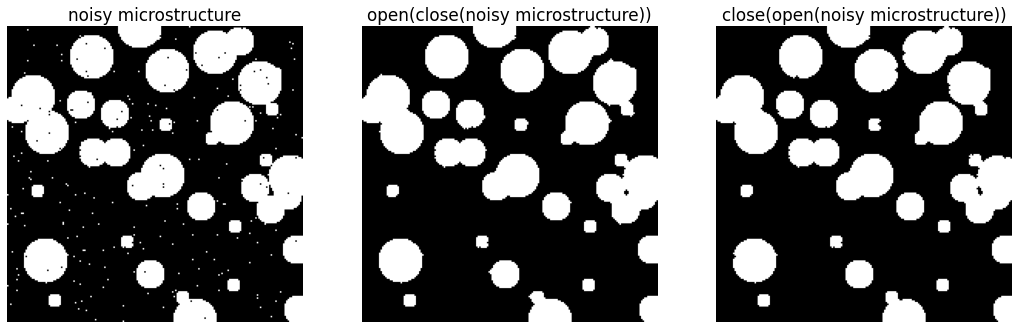

In [13]:
k = kernels.disc( 3 )

fig, ax= plt.subplots(1,3,figsize=(18,7))
ax[0].imshow( img, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('noisy microstructure')
new_img = morph_opening( morph_closing( img, k, onepad=True), k, onepad=True )
ax[1].imshow( new_img, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('open(close(noisy microstructure))')

new_img = morph_closing( morph_opening( img, k, onepad=True), k, onepad=True )
ax[2].imshow( new_img, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('close(open(noisy microstructure))')


## Image entropy

- *(optional)* step 1: filter image: $ A' = \mathrm{filter}(A, f)$ 
- step 2: compute image entropy

$$ S = - A' \, \log_2( \max( \theta, A' )) -  (1 - A') \, \log_2( \max( \theta, (1 - A') ))$$
(here $\theta>0$ prevents `NaN` and `inf`)

### Derivation
Let $A$ denote the volume fraction of phase 1 $\blacktriangleright$ in a binary image this is either 0 or 1 corresponding to one phase per pixel. In the filtered image, this is sort of a nonlocal value that accounts for pixels in the neighborhood defined by the kernel size. Then $A'$ is a kernel-dependent moving average of the volume fraction (it is asserted that the kernel sums to 1). The events are then:
- phase 0 with probability $(1-A')$
- phase 1 with probability $A'$

The information entropy is measured as:

$$ S = - \sum_{i=1}^N  P_i \, \log_2(P_i) $$

where $N$ is the number of possible events: here, $N=2$. This also teases how the entropy in an $N$ phase material can be computed: Each (but one) phase indicator function must be filtered individually. The last phase is then obtained as the complementary event to finding any of the other phases. Then the entropy can be computed by the above formula. If the kernel is truely inside any individual phasen, then the entropy gets 0. Only points close to the interface of different phases will yield nonzero entropy, making the entropy a good candidate for interface detection. The entropy is maximized if $P_i=1/N$ for all of the $N$ phases yielding $S=\log_2 (N)$.

**Remark** The entropy is measured in bits, since $\log_2$ is used. Other logarithms can be used yielding different *units* of the entropy. For a $N$-phasic material, $\log_N$ will provide a measure scaling between 0 and 1.

Text(0.5, 1.0, 'image entropy + segmentation ($\\theta$=0.750)')

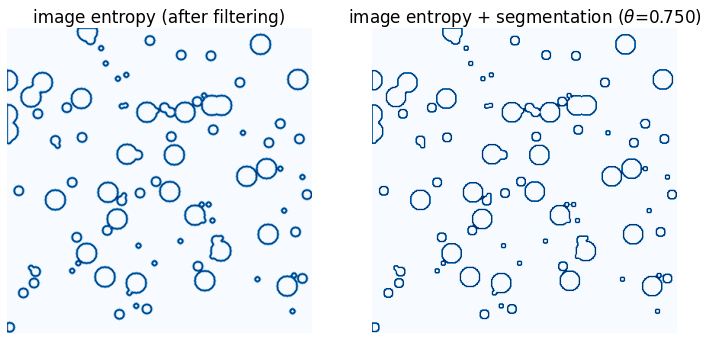

In [14]:
theta = 1e-6
k = kernels.disc(5, kind='uniform') 

img = circular_ms(N=100, n_x=400, radii=[7, 13, 27])

B_in = improcess.convolution( img.astype('float'), k )
S = - B_in * np.log2( np.maximum( theta, B_in ) ) - (1-B_in) * np.log2( np.maximum( theta, 1-B_in ) )
fig, ax = plt.subplots(1,2,figsize=(12,7))
ax[0].imshow(S, cmap=plt.cm.Blues)
ax[0].axis('off')
ax[0].set_title('image entropy (after filtering)')
theta = 0.75
ax[1].imshow((S>theta), cmap=plt.cm.Blues)
ax[1].axis('off')
ax[1].set_title(r'image entropy + segmentation ($\theta$=%.3f)'%theta)


### Computation of the 2PC

The construction of the 2PC of bi-phasic materials is straight-forward:
- compute one autocorrelations, e.g. $c_{11}(\boldsymbol{r})$
- given the phase volume fractions derive the remaining 3 correlations:

$$ c_{00} (\boldsymbol{r}) = 1-2f_1 + c_{11}(\boldsymbol{r}), \qquad
c_{01} (\boldsymbol{r}) = f_1 - c_{11}(\boldsymbol{r}) = c_{01}(-\boldsymbol{r}), \qquad
c_{10} (\boldsymbol{r}) = f_1 - c_{11}(\boldsymbol{r}) = c_{01}(\boldsymbol{r}) = (-\boldsymbol{r})$$

- notice the symmetry of $c_{01}$ and $c_{10}$ which is due to the symmetry of the autocorrelation!
- alternatively (see code below): $c_{01}(\boldsymbol{r}) = c_{10}(-\boldsymbol{r})$

verification: c[0] vs. reference - error:    0.000 %
verification: c[1] vs. reference - error:    0.000 %
verification: c[2] vs. reference - error:    0.000 %
verification: c[3] vs. reference - error:    0.000 %


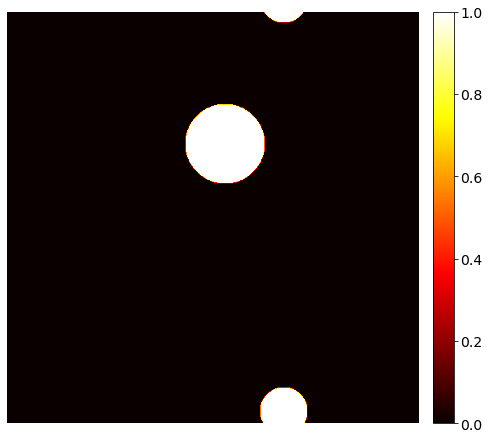

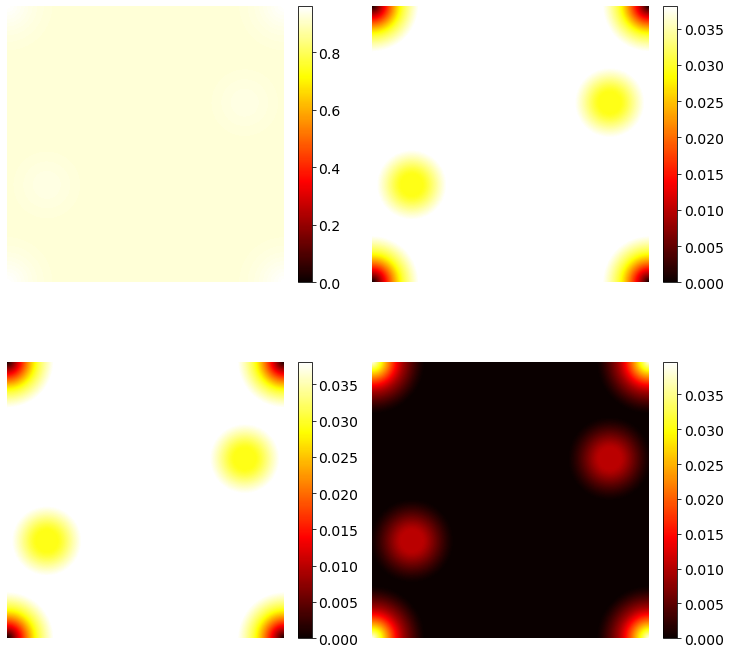

In [15]:
#img = circular_ms( N=400, n_x=512, radii=np.array([5, 10, 25]))
img = circular_ms( N=2, n_x=512, radii=[60,100], periodic=True)
fig,ax = plt.subplots(1,1,figsize=(8,8))

divider = make_axes_locatable(ax)
cax=divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar( ax.imshow(img, cmap=plt.cm.hot), cax=cax)
ax.axis('off')


f1= img.sum()/img.size
f0= 1-f1

f_chi1=fft2(img)

c = []
# construct c01, c10 and c00 from c11 only:
c11 = ifft2(f_chi1.conj() * f_chi1).real / img.size 
c00 = 1.0 - 2*f1 + c11 # = f0 - f1 + c11
c10 = f1 - c11
# point mirror c10 around the origin (attention! roll is required)
c01 = np.roll(np.flipud( np.fliplr( c10 )),[1, 1],axis=[0, 1])

c.append( c00 )
c.append( c01 )
c.append( c10 )
c.append( c11 )

rng = [ f0, f0*f1, f0*f1, f1 ]

fig,ax = plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()

ct=0
for AX in ax:
    divider = make_axes_locatable(AX)
    cax=divider.append_axes('right', size='5%', pad=0.2)
    fig.colorbar( AX.imshow(c[ct], cmap=plt.cm.hot, vmin=0, vmax=rng[ct]), cax=cax)
    ct+=1


f_chi0  = fft2( 1-img )
C=[]
C.append( ifft2(f_chi0.conj() * f_chi0).real / img.size )
C.append( ifft2(f_chi0.conj() * f_chi1).real / img.size )
C.append( ifft2(f_chi1.conj() * f_chi0).real / img.size ) 
C.append( ifft2(f_chi1.conj() * f_chi1).real / img.size )

for ct in range(4):
    print('verification: c[%d] vs. reference - error: %8.3f %%' \
          % (ct, 100.0*np.linalg.norm((C[ct]-c[ct]).flatten())/np.linalg.norm(C[ct].flatten()) ))

for AX in ax.flatten():
    AX.axis('off')


## Getting image information using `skimage`
- e.g. topological information (such as Euler number)


Euler number of the original image: 0 ( 1 - # white islands, left image )
Euler number of the inverted image: 1 ( 1 - # white islands, right image )
(regions touching the boundary are not counted!)


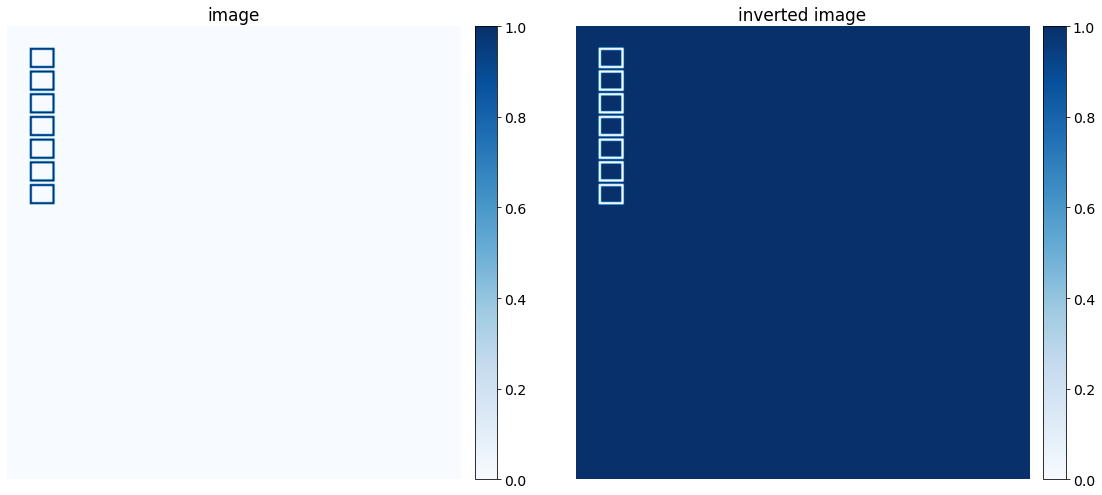

In [16]:
img = np.zeros((200,200),dtype='uint8')
A = np.ones([20,20], dtype='uint8')
s=slice(0,10)
l=slice(0,5)
for i in range(7):
    s = slice( (10*i+10), (10*i+18) )
    img[ s, 10] = 1
    img[ s, 20] = 1
    img[ 10*i+10, 10:21 ] = 1
    img[ 10*i+18, 10:21 ] = 1
#A[3:5,4:7] = 0
#A[13:15,4:7] = 0
fig,ax=plt.subplots(1,2,figsize=(16,7))
p = ax[0].imshow(img, cmap=plt.cm.Blues)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size="5%", pad=0.2)
fig.colorbar(p, cax=cax)
ax[0].axis('off')
ax[0].set_title('image')
improps = skimage.measure.regionprops(img)[0]
print('Euler number of the original image: %i ( 1 - # white islands, left image )' % improps.euler_number )


divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size="5%", pad=0.2)
ax[1].axis('off')
ax[1].set_title('inverted image')
fig.colorbar(ax[1].imshow(1-img, cmap=plt.cm.Blues), cax=cax )

improps = skimage.measure.regionprops(1-img)[0]
print('Euler number of the inverted image: %i ( 1 - # white islands, right image )' % improps.euler_number )

print('(regions touching the boundary are not counted!)')
fig.tight_layout(h_pad=1)

### Exploring further regionprops

In [17]:
help(skimage.measure.regionprops)

Help on function regionprops in module skimage.measure._regionprops:

regionprops(label_image, intensity_image=None, cache=True, coordinates=None, *, extra_properties=None)
    Measure properties of labeled image regions.
    
    Parameters
    ----------
    label_image : (M, N[, P]) ndarray
        Labeled input image. Labels with value 0 are ignored.
    
        .. versionchanged:: 0.14.1
            Previously, ``label_image`` was processed by ``numpy.squeeze`` and
            so any number of singleton dimensions was allowed. This resulted in
            inconsistent handling of images with singleton dimensions. To
            recover the old behaviour, use
            ``regionprops(np.squeeze(label_image), ...)``.
    intensity_image : (M, N[, P][, C]) ndarray, optional
        Intensity (i.e., input) image with same size as labeled image, plus
        optionally an extra dimension for multichannel data.
        Default is None.
    
        .. versionchanged:: 0.18.0
         